In [1]:
import codecs
import pandas as pd
import numpy as np
import  random

from nltk.corpus import stopwords
from pymystem3 import Mystem # лемматизация русских слов, можно установить через pip install
from string import punctuation

import re
import bs4

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# тестовая выборка
test_raw=[]
with codecs.open("test.csv", "r", "utf_8_sig") as f:
    data = f.read()
    parser = bs4.BeautifulSoup(data, 'lxml')
    x = parser.findAll('review')
    test_raw = []
    for text in x:
        test_raw.append(text.text)

In [4]:
mystem = Mystem() 
russian_stopwords = stopwords.words("russian")

In [8]:
# функция для предобработки сырых отзывов
def text_filter(texts_to_filter):
    stop_words = stopwords.words('russian')
    filtered_texts = []
    for text in texts_to_filter:
        text= re.sub(r'[^\w\s]',' ',text) # убираем знаки пунктуации и прочие символы
        text = re.sub(' \d+', '', text) # убираем числа
        text= re.sub(r"\s+", ' ', text).strip() # убираем лишние пробелы 
        tokens = mystem.lemmatize(text.lower()) # лемматизация
        tokens = [token for token in tokens if token not in stop_words and token != " " and token.strip() not in punctuation]
        text = " ".join(tokens)
        filtered_texts.append(text)
    return filtered_texts

In [9]:
%%time
test = text_filter(test_raw)

Wall time: 2min 13s


In [7]:
test_raw[1] # пример сырого отзыва из тестовой выборки

'ценанадежность-неубиваемостьдолго держит батарею 4 дня стабильно как телефон, 3-4 как плеер если \rпостоянно долбиться в уши и звонить по паре часо на дню, игры и, конечно,  смс , в месяц около 200 шт набирается.\r Максимальное время работы 5 дней в щадящем режиме.2 simqwerty рулит -после нее набор смс на обычных сенсорниках и кнопочных -просто издивательствогромкий ,чистый звук (хорошо варьируется как в + так и в -)значение hot кнопок (верхняя панель до основной раскладки цифры/буквы) задается под себямного цветных панелек с пластиковым защитным  экраном,переставляются легко(те родной экран телефона никогда не поцарапается)кнопки не стираютсякак не странно достойные фото, нет не спорю не 25 мегапикселей, но  отснять рассписание или конспекты, зафотать пейзаж за окном автобуса получается вполне пристойносохранение файлов,отснятых фото, переброшенных песен происходит  на карту памяти  и это оч удобно, карточки кушает до 32 Гб !удобный ашевский бонус смс чат с аббанентом\rт.е.  вы может

In [8]:
test[1] # пример отзыва из тестовой выборки после обработки

'ценанадежность неубиваемостьдолго держать батарея день стабильно телефон плеер постоянно долбиться ухо звонить пара часо день игра смс месяц около шт набираться максимальный время работа день щадить режим simqwerty рулить набор смс обычный сенсорник кнопочный просто издивательствогромкий чистый звук варьироваться значение hot кнопка верхний панель основной раскладка цифра буква задаваться себямный цветной панелька пластиковый защитный экран переставляться легко родной экран телефон поцарапаться кнопка стираютсякак странный достойный фото спорить мегапиксел отснимать рассписание конспект зафотать пейзаж окно автобус получаться вполне пристойносохранение файл отснимать фото перебрасывать песня происходить карта память это оч удобный карточка кушать гб удобный ашевский бонус смс чат аббанент т е мочь видеть весь ветка беседа конкретный человек искать куча входить смс нужный информация работать чисто галюнов падать шврясться купаться использоваться тело плеер метро поезд слышно ухо юзай с

### Парсинг:
В качестве обучающей выборки были собраны отзывы на смартфоны с сайта Отзовик (http://otzovik.com/technology/communication/cellular_phones/)

Мы распарсили:
- 2313 отзывов-комментариев (label = 1 если в графе "рекомендую друзьям" указано "ДА", если "НЕТ", то label = 0) - см. parse_otzovic_reviews.py, результат в responses_texts.txt
- 4429 отзывов с пометкой достоинства (label = 1) / недостатки (label = 0) - см. parse_otzovic_reviews_short.py, результат в responses_texts_short.txt

Ссылки на страницы с отзывами получили с помощью parse_otzovic.py (результат в responses.txt)

Для парсинга использовали библиотеки request и bs4. 

Чтобы нас не забанили, также использовали библиотеку fake_useragent (для имитации запроса от браузера, а не робота) и список бесплатных прокси (proxies.csv, нужно обновлять) с сайта https://free-proxy-list.net/

#### Отзывы с сайта отзовик (комментарии)

In [10]:
labels=[]
train_raw=[]
with codecs.open("responses_texts.txt", "r", "utf_8_sig") as f:
    for line in f.readlines():
        labels.append(int(line[0]))
        train_raw.append(line[2:-1])

In [11]:
%%time
train = text_filter(train_raw) # фильтруем данные

Wall time: 44min 26s


In [11]:
train_raw[2] # пример сырого отзыва из обучающей выборки

'Так случилось, что мобильные телефоны у меня долго не живут, через полтора - два года начинают ломаться. Приходится искать замену. Требования к моделям у меня минимальные: экран побольше, чтобы удобно было читать книги, хорошая камера, чтобы делать фотографии, удобное меню и цена в районе 10000. Предпоследним смартфоном был Meizu, у которого очень быстро перестала работать единственная кнопка, сканер отпечатка пальцев, что несло большие неудобства. Мне было легче искать новый, чем сдать смартфон в ремонт на месяц.И я нашла VIVO 81 в интернете в салоне МТС. Эта модель есть в красном и черном цвете, в салоне был только черный.Сразу скажу, это оказался замечательный телефон.Тонкий, удобно лежит в руке. Большой яркий экран, разрешение экрана: 1520 x 720, ,диагональ 6,2.Картинки на экране меняются при каждом включении телефона, это занятно и интересно, добавляются новые.Емкость аккумулятора: 3260 mAh, мне хватает на 3 дняУдобное меню, для меня самое удобное из всех моделей, которые у меня 

In [12]:
train[2] # пример отзыва из обучающей выборки после обработки

'случаться мобильный телефон долго жить полтора год начинать ломаться приходиться искать замена требование модель минимальный экран удобно читать книга хороший камера делать фотография удобный меню цена район предпоследний смартфон meizu который очень быстро переставать работать единственный кнопка сканер отпечаток палец нести большой неудобство легко искать новый сдавать смартфон ремонт месяц находить vivo интернет салон мтс модель красный черный цвет салон черный сразу сказать это оказываться замечательный телефон тонкий удобно лежать рука большой яркий экран разрешение экран x диагональ картинка экран меняться каждый включение телефон это занятный интересно добавляться новый емкость аккумулятор mah хватать дняудобный меню самый удобный весь модель который сканер отпечаток палец очень это рад распознавание лицо значный пароль графический ключ основной камера мп снимок получаться неплохой качество объем оперативный память гб симочный место microsd радовать недостаток пока находить'

#### Отзывы с сайта отзовик (плюсы/минусы). Очень короткие комментарии мы удалим, т.к. они не особо информативны, и не похожи на тестовую выборку

In [12]:
labels_short=[]
train_short_raw=[]
with codecs.open("responses_texts_short.txt", "r", "utf_8_sig") as f:
    for line in f.readlines():
        if (len(line[2:-1].split()) > 7): # выбрасываем которкие комментарии
            text = line[2:-1]
            label = int(line[0])
            labels_short.append(label)
            train_short_raw.append(text)

In [13]:
%%time
train_short = text_filter(train_short_raw) # фильтруем данные

Wall time: 21min 34s


In [15]:
train_short_raw[0]

'Красочный AMOLED-экран, 16 мегапиксельная камера, хороший телефон в соотношении цена/качество'

In [16]:
train_short[0]

'красочный amoled экран мегапиксельный камера хороший телефон соотношение цена качество'

In [14]:
train = train + train_short
labels = labels + labels_short

In [15]:
# перемешаем данные
combined = list(zip(train, labels))
random.shuffle(combined)

train[:], labels[:] = zip(*combined)

In [16]:
# Pipeline модели
def text_classifier(vectorizer, classifier):
    return Pipeline(
            [("vectorizer", vectorizer),
            ("classifier", classifier)]
        )

In [24]:
%%time

# Посмотри различные алгоритмы и векторайзеры
for vect in [CountVectorizer, TfidfVectorizer]:
    for alg in [LogisticRegression(), LinearSVC(), SGDClassifier(shuffle=True, random_state=0)]:
        for ngram_range in [(1,1),(1,2),(1,3)]:            
            cvs = cross_val_score(text_classifier(vect(ngram_range=ngram_range), alg), train, labels, cv=5).mean()
            print(f'algorithm: {type(alg).__name__}, vectorizer: {type(vect(ngram_range=ngram_range)).__name__}, ngram_range: {ngram_range}, cv mean score: {cvs.mean()}')

algorithm: LogisticRegression, vectorizer: CountVectorizer, ngram_range: (1, 1), cv mean score: 0.8646671680215812
algorithm: LogisticRegression, vectorizer: CountVectorizer, ngram_range: (1, 2), cv mean score: 0.876653770933302
algorithm: LogisticRegression, vectorizer: CountVectorizer, ngram_range: (1, 3), cv mean score: 0.8769414719072817
algorithm: LinearSVC, vectorizer: CountVectorizer, ngram_range: (1, 1), cv mean score: 0.8333822807473776
algorithm: LinearSVC, vectorizer: CountVectorizer, ngram_range: (1, 2), cv mean score: 0.8567788290481613
algorithm: LinearSVC, vectorizer: CountVectorizer, ngram_range: (1, 3), cv mean score: 0.8582391086707089
algorithm: SGDClassifier, vectorizer: CountVectorizer, ngram_range: (1, 1), cv mean score: 0.8447721313164891
algorithm: SGDClassifier, vectorizer: CountVectorizer, ngram_range: (1, 2), cv mean score: 0.8535470678955924
algorithm: SGDClassifier, vectorizer: CountVectorizer, ngram_range: (1, 3), cv mean score: 0.8570631126590491
algorith

попробуем комбинацию algorithm: LinbearSVC, vectorizer: TfidfVectorizer, ngram_range: (1, 1)

### algorithm: LinbearSVC, vectorizer: TfidfVectorizer, ngram_range: (1, 1)

In [26]:
vect = TfidfVectorizer
clf = LinearSVC()     
cvs = cross_val_score(text_classifier(vect(ngram_range=(1,1)), clf), train, labels, cv=5).mean()
print(f'algorithm: {type(alg).__name__}, vectorizer: {type(vect(ngram_range=(1,1))).__name__}, ngram_range: {(1,1)}, cv mean score: {cvs.mean()}')

algorithm: LogisticRegression, vectorizer: TfidfVectorizer, ngram_range: (1, 1), cv mean score: 0.8757770098085447


In [27]:
# подберем параметр С классификатора, параметры векторайзера оставим по умолчанию
for C in np.arange(1,20)/20: # 0.35 - is the best
    clf = LinearSVC(C=C, random_state=0)
    vect = TfidfVectorizer(ngram_range=(1,1))
    cvs = cross_val_score(text_classifier(vect, clf), train, labels, cv=5).mean()
    print(f'C {C} : {cvs:.4f}')

C 0.05 : 0.8343
C 0.1 : 0.8650
C 0.15 : 0.8734
C 0.2 : 0.8796
C 0.25 : 0.8796
C 0.3 : 0.8793
C 0.35 : 0.8799
C 0.4 : 0.8807
C 0.45 : 0.8790
C 0.5 : 0.8784
C 0.55 : 0.8793
C 0.6 : 0.8787
C 0.65 : 0.8790
C 0.7 : 0.8781
C 0.75 : 0.8775
C 0.8 : 0.8767
C 0.85 : 0.8764
C 0.9 : 0.8752
C 0.95 : 0.8755


In [17]:
# Обучим модель с лучшими параметрами

vectorizer = TfidfVectorizer(ngram_range=(1,1))
classifier = LinearSVC(C=0.35, random_state=0)
ppl = text_classifier(vectorizer, classifier)

ppl.fit(train,labels)
y = ppl.predict(test)

# посмотрим на несколько прогнозов
for i in range(5):
    print(y[i],':', test[i],'\n')

0 : ужасно слабый аккумулятор это основной минус аппарат разряжаться буквально пара час включать wifi макс подсветка например играть смотреть видео следовательно использовать постоянный возможность подзарядиться качество звук динамик далеко высота наблюдаться незначительный тормоз некоторый приложение вообще меню очень мало встроенный память приложение устанавливаться именно туда связанный неудобство нужно постоянно переносить карта память несколько неудобно нету отдельный кнопка фото подумывать купить батарея больший емкость мб изменяться 

1 : ценанадежность неубиваемостьдолго держать батарея день стабильно телефон плеер постоянно долбиться ухо звонить пара часо день игра смс месяц около шт набираться максимальный время работа день щадить режим simqwerty рулить набор смс обычный сенсорник кнопочный просто издивательствогромкий чистый звук варьироваться значение hot кнопка верхний панель основной раскладка цифра буква задаваться себямный цветной панелька пластиковый защитный экран пер

In [18]:
answer = pd.DataFrame(data=ppl.predict(test),columns=['y'])
answer.index = np.arange(len(test))
answer.index.name = 'Id'
answer['y']=answer['y'].apply(lambda x: {1: "pos", 0: "neg"}.get(x,x))
# answer.to_csv('answer1.csv')
answer.head()

,y
Id,
0,neg
1,pos
2,neg
3,neg
4,pos


kaggle submission score : 0.9000
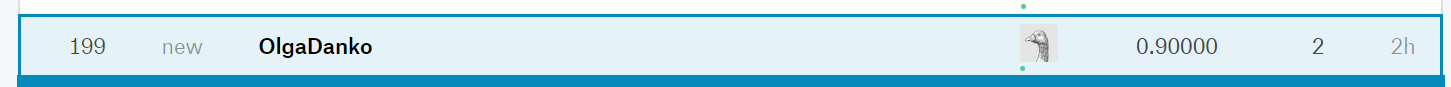

In [19]:
from sklearn.externals import joblib
# now let's save it to a file
joblib.dump(ppl, 'ppl.pkl') 

['ppl.pkl']

In [23]:
ppl.predict(text_filter(["люди всем кто хочет купить покупайте. советую. это бомба."]))

array([0])

In [22]:
text_filter(["люди всем кто хочет купить покупайте. советую. это бомба."])

['человек хотеть купить покупать советовать это бомба']